In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SMALL_FONT_SIZE = 12
MEDIUM_FONT_SIZE = 16
LARGE_FONT_SIZE = 20
XLARGE_FONT_SIZE = 24

plt.rc("font", size=MEDIUM_FONT_SIZE)
plt.rc("axes", titlesize=LARGE_FONT_SIZE)
plt.rc("axes", labelsize=LARGE_FONT_SIZE)
plt.rc("xtick", labelsize=MEDIUM_FONT_SIZE)
plt.rc("ytick", labelsize=MEDIUM_FONT_SIZE)
plt.rc("legend", fontsize=MEDIUM_FONT_SIZE)
plt.rc("figure", titlesize=LARGE_FONT_SIZE)

In [25]:
def plot_main_metric_model_scaling(scvi_models, datasets, evaluation, task, y_lim_low=0.6, title_prefix="", file_prefix=""):
    sns.set_style("ticks")

    num_rows = 1
    num_columns = len(datasets)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 6))

    for j, dataset in enumerate(datasets):
        metrics_dfs = []
        for i, model in enumerate(scvi_models):
            print("plotting:")
            print(evaluation, model, dataset)
    
            if task == "classification":
                metric = "micro_f1"
                y_label = "Micro F1 Score"
            if task == "integration":
                metric = "avg_bio"
                y_label = "Avg. BIO"
    
            if evaluation == "finetune" and task == "classification":
                metrics_df = pd.read_csv(f"metrics_csvs/{model}_finetune_classification_eval_results.csv", index_col=0)
                logistic_regression_baseline_df = pd.read_csv(f"metrics_csvs/finetune_classification_logistic_regression_variable_genes_baselines.csv", index_col=0)
                logistic_regression_baseline_df = logistic_regression_baseline_df[logistic_regression_baseline_df.dataset == dataset]
    
                logistic_regression_baseline = logistic_regression_baseline_df["micro_f1"][0]
    
            if evaluation == "zeroshot" and task == "classification":
                metrics_df = pd.read_csv(f"metrics_csvs/{model}_zeroshot_classification_eval_results.csv", index_col=0)
                hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_variable_genes_baselines.csv", index_col=0)
                pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_classification_pca_baselines.csv", index_col=0)
    
                
            if evaluation == "zeroshot" and task == "integration":
                metrics_df = pd.read_csv(f"metrics_csvs/{model}_zeroshot_integration_eval_results.csv", index_col=0)
    
                hvg_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_variable_genes_baselines.csv", index_col=0)
                pca_baseline_df = pd.read_csv(f"metrics_csvs/zero_shot_integration_pca_baselines.csv", index_col=0)
            
            # subset to the dataset of interest
            metrics_df = metrics_df[metrics_df.dataset == dataset]
    
            # default matplotlib colors:
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
            if evaluation == "zeroshot":
                hvg_baseline_df = hvg_baseline_df[hvg_baseline_df.dataset == dataset]
                pca_baseline_df = pca_baseline_df[pca_baseline_df.dataset == dataset]
                
                hvg_baseline = hvg_baseline_df[metric][0]
                pca_baseline = pca_baseline_df[metric][0]
    
            # rename categories for plotting
            metrics_df["downsampling_method"] = pd.Categorical(metrics_df["downsampling_method"]).rename_categories({
                'randomsplits': 'Random', 
                'random': 'Random', 
                'celltype_reweighted': 'Cell Type\nReweighted',
                'geometric_sketch': "Geometric Sketching",
                'geometric_sketching': "Geometric Sketching",
                'spikein_10': "Spike-in (10%)",
                'spikein_50': "Spike-in (50%)",
                })
    
            metrics_df["model"] = model
            metrics_dfs.append(metrics_df)


        ax = axes[j]
        metrics_df = pd.concat(metrics_dfs)

        # remove 0pcts since only scvi_1x has them right now
        metrics_df = metrics_df[metrics_df.percentage != 0]
        
        LINEWIDTH = 3
    
        # main plot
        sns.lineplot(x='percentage',
                     y=metric,
                     hue='model',
                     data=metrics_df,
                     errorbar='se',
                     linewidth=LINEWIDTH,
                     ax = ax,
                     palette='viridis')
        
        # add horizontal lines for baselines
        if evaluation == "finetune":
            # add line for logistic regression
            ax.hlines(y=logistic_regression_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Logistic\nRegression Baseline', linewidth=LINEWIDTH)
        if evaluation == "zeroshot":
            # add line for HVGs
            ax.hlines(y=hvg_baseline, xmin=0, xmax=100, color='black', linestyle='dotted', label='HVG Baseline', linewidth=LINEWIDTH)
            # add line for PCA
            ax.hlines(y=pca_baseline, xmin=0, xmax=100, color='black', linestyle='dashed', label='PCA Baseline', linewidth=LINEWIDTH)
    
        # set axes and legend
        ax.grid(False)
        ax.set_xlabel("")
        ax.set_ylabel("")
    
        ax.set_xlim([-1, 100])
        ax.set_ylim([y_lim_low, 1.0])

        if dataset == "kim_lung":
            dataset = "lung"
        ax.title.set_text(dataset.capitalize())
    
        ax.get_legend().remove() # have one legend for all models
    
        # remove top and right spines from axis
        ax.spines[['right', 'top']].set_visible(False)

    
        # set axis line widths
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(LINEWIDTH)


    if evaluation == "zeroshot":
        prefix = " Zero-Shot"
    if evaluation == "finetune":
        prefix = " Fine-Tuned"

    if task == "classification":
        suffix = " Classification"
    elif task == "integration":
        suffix = " Integration"

    fig.suptitle(title_prefix + prefix + suffix, fontsize=XLARGE_FONT_SIZE, y=1.01)

    fig.supxlabel("Percentage of Full Pre-Training Dataset", y=0.2)
    fig.supylabel(y_label, y = 0.25 + 0.375, x=0.07)

    # grab legend labels from subplot
    handles, labels = ax.get_legend_handles_labels()


    # add legend blow plots
    fig.subplots_adjust(bottom=0.35)
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), title='', ncol=5)

    plot_file = f"figures/model_scaling/{file_prefix}_{evaluation}_{task}.png"
    print("Saving:", plot_file)
    plt.savefig(plot_file, bbox_inches="tight", dpi=1200)

plotting:
zeroshot scVI hematopoiesis
plotting:
zeroshot SSL hematopoiesis
plotting:
zeroshot SSL_VAE hematopoiesis
plotting:
zeroshot scVI periodontitis
plotting:
zeroshot SSL periodontitis
plotting:
zeroshot SSL_VAE periodontitis
plotting:
zeroshot scVI intestine
plotting:
zeroshot SSL intestine
plotting:
zeroshot SSL_VAE intestine
plotting:
zeroshot scVI placenta
plotting:
zeroshot SSL placenta
plotting:
zeroshot SSL_VAE placenta
Saving: figures/model_scaling/SSL_with_VAE_loss_zeroshot_classification.png
plotting:
zeroshot scVI kim_lung
plotting:
zeroshot SSL kim_lung
plotting:
zeroshot SSL_VAE kim_lung
plotting:
zeroshot scVI periodontitis
plotting:
zeroshot SSL periodontitis
plotting:
zeroshot SSL_VAE periodontitis
plotting:
zeroshot scVI renal
plotting:
zeroshot SSL renal
plotting:
zeroshot SSL_VAE renal
plotting:
zeroshot scVI liver
plotting:
zeroshot SSL liver
plotting:
zeroshot SSL_VAE liver
Saving: figures/model_scaling/SSL_with_VAE_loss_zeroshot_integration.png


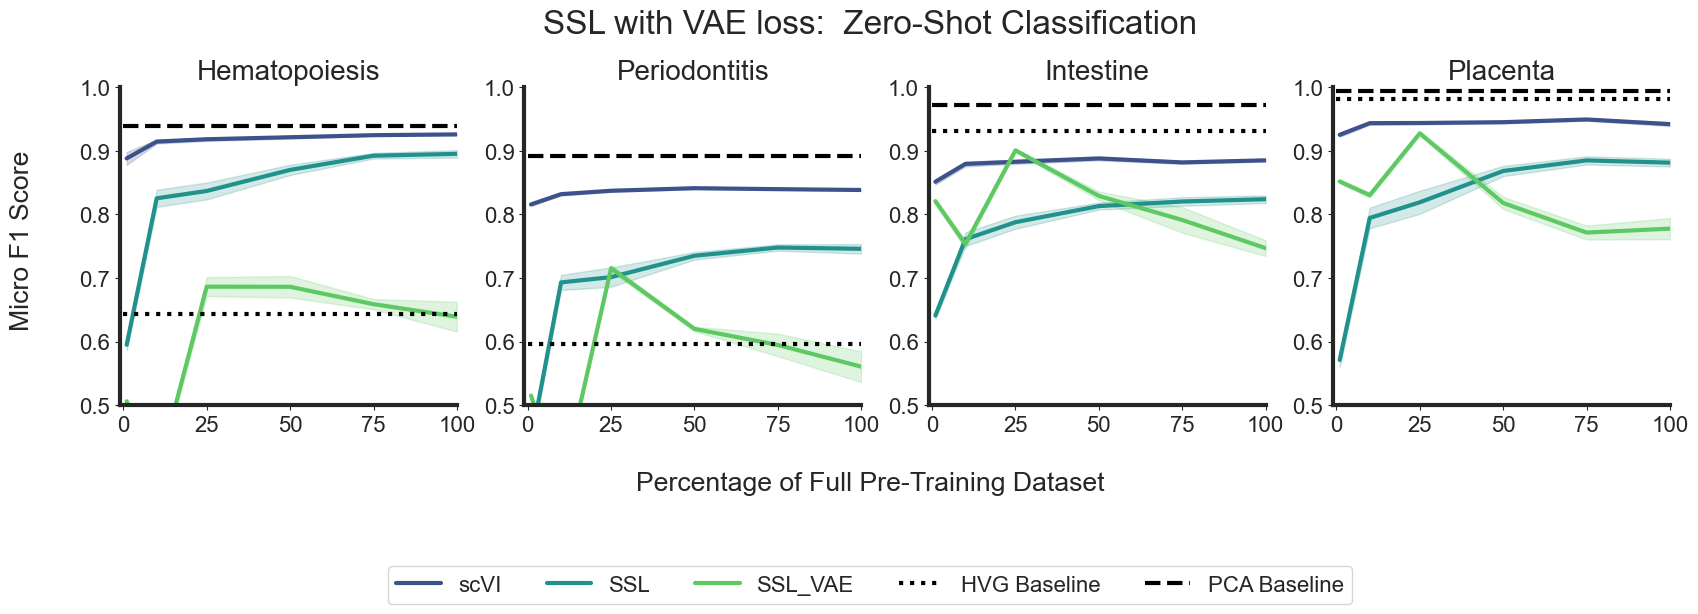

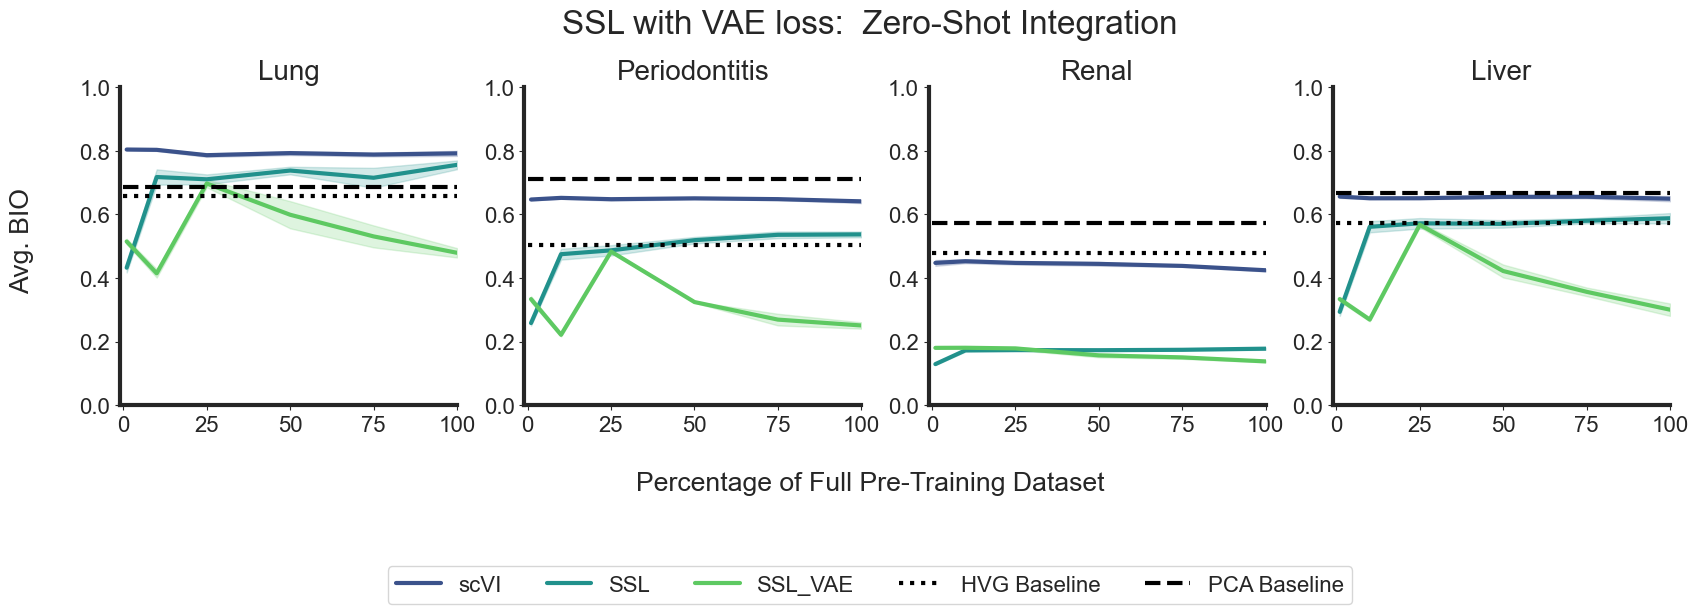

In [31]:
datasets = ["hematopoiesis", "periodontitis", "intestine", "placenta"]

models = ["scVI", "SSL", "SSL_VAE"]
file_prefix = "SSL_with_VAE_loss"
title_prefix = "SSL with VAE loss: "

eval_type = "zeroshot" # "finetune"
task = "classification"
plot_main_metric_model_scaling(models, datasets, eval_type, task,
                               title_prefix=title_prefix, file_prefix=file_prefix, y_lim_low=0.5)

#eval_type = "finetune"
#plot_main_metric_model_scaling(models, datasets, eval_type, task, 
#                               title_prefix=title_prefix, file_prefix=file_prefix, y_lim_low=0.5)


datasets = ["kim_lung", "periodontitis", "renal",  "liver"]
eval_type = "zeroshot"
task = "integration"
plot_main_metric_model_scaling(models, datasets, eval_type, task,
                               title_prefix=title_prefix, file_prefix=file_prefix, y_lim_low=0)
